# ST-HDBSCAN: Spatiotemporal Hierarchical DBSCAN for Trajectory Data

## Abstract

The study of human mobility has advanced greatly in recent years due to the availability of
commercial large-scale GPS trajectory datasets [3]. However, the validity of findings that use
these datasets depends heavily on the robustness of their pre-processing methods. An important
step in the processing of mobility data is the detection of stops within GPS trajectories, for
which many clustering algorithms have been proposed [4, 8, 6, 1]. Yet, the high sparsity of
commercial GPS data can affect the performance of these stop-detection algorithms.
In the case of DBSCAN, while it initially identifies dense regions, it can often over-cluster
or under-cluster due to noise and weakly connected points given the chosen ε. ST-DBSCAN [4]
uses two distance thresholds, Eps1 for spatial and Eps2 for non-spatial values. The algorithm
compares the average non-spatial value, such as temperature, of a cluster with a new com-
ing value, to prevent merging adjacent clusters. Nevertheless, datasets that include this kind
of information are not comparable to realistic GPS-based trajectories. A promising algorithm
is T-DBSCAN [6], which searches forward in time for a continuous density-based neighbor-
hood of core points. Points spatially close, within Eps, and within a roaming threshold, CEps, are included in a cluster. Additionally, we used a time-augmented DBSCAN algorithm, TA-DBSCAN, which recursively processes the clusters obtained from DBSCAN to address the issue of initial clusters overlapping in time. However, methods [9] that validate stop-detection algorithms based on synthetic data show that these can omit, merge, or split stops based on the selection of epsilon and sparsity of the data.

If we define parameters that may be considered fine (low ε), it might completely miss a stop at a larger location. In contrast, coarse parameters (large ε) may struggle to differentiate stops within small neighboring locations [3]. Since different venues vary in stop durations and areas, this could influence the parameter choices [9]. To address this parameter selection limitation, we propose a spatiotemporal variation of Hierarchical DBSCAN [5], ST-HDBSCAN. Unlike DBSCAN, which relies on one threshold of density to cluster points, our variation constructs separate structures for space and time distances that preserve density-based connections in these two dimensions. This approach ensures that when pruning the hierarchical tree structure needed for cluster formation, we account for varying spatiotemporal densities. As a result, clusters emerge naturally without requiring specific time and space thresholds, working effectively across different data sparsity levels.

In [113]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
import nomad.io.base as loader
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.city_gen as cg

In [35]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime',
             'latitude':'latitude',
             'longitude':'longitude'}

# data = loader.from_file("../../nomad/data/gc_sample.csv")
data = loader.from_file("../../nomad/data/gc_3_stops.csv", timestamp='unix_timestamp', datetime='local_timestamp', user_id='identifier')

/Users/andresmondragon/nomad/nomad/io/base.py:614: UserWarning: The 'local_timestamp' column has timezone-naive records consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column has timezone-naive records consider localizing or using unix timestamps.")


In [36]:
data.rename(columns={'unix_timestamp':'timestamp'}, inplace=True)

In [37]:
data

,x,y,local_timestamp,timestamp,identifier
0,14.500000,11.500000,2024-06-01 00:00:00,1717200000,Charlie
1,14.500000,11.500000,2024-06-01 00:01:00,1717200060,Charlie
2,14.500000,11.500000,2024-06-01 00:02:00,1717200120,Charlie
3,14.500000,11.500000,2024-06-01 00:03:00,1717200180,Charlie
4,14.672353,11.045084,2024-06-01 00:04:00,1717200240,Charlie
...,...,...,...,...,...
296,19.891026,10.332496,2024-06-01 04:56:00,1717217760,Charlie
297,19.891026,10.332496,2024-06-01 04:57:00,1717217820,Charlie
298,19.891026,10.332496,2024-06-01 04:58:00,1717217880,Charlie
299,19.692934,9.845237,2024-06-01 04:59:00,1717217940,Charlie


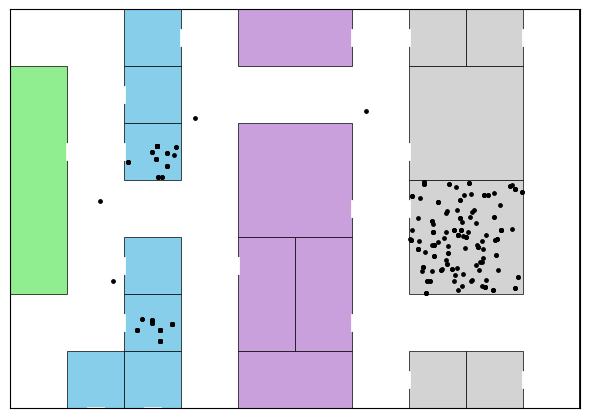

In [38]:
%matplotlib inline

plot_df = data.copy()

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
plt.tight_layout()
plt.show()

In [106]:
time_pairs, times = HDBSCAN._find_bursts(times = data['timestamp'], time_thresh = 10, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(data, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=5)
mrd = HDBSCAN._compute_mrd_graph(coords, times, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 10)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(label_history_df, selected_clusters)

In [125]:
sample_labels_hdbscan['cluster'].unique()

array([-1,  3,  4,  2])

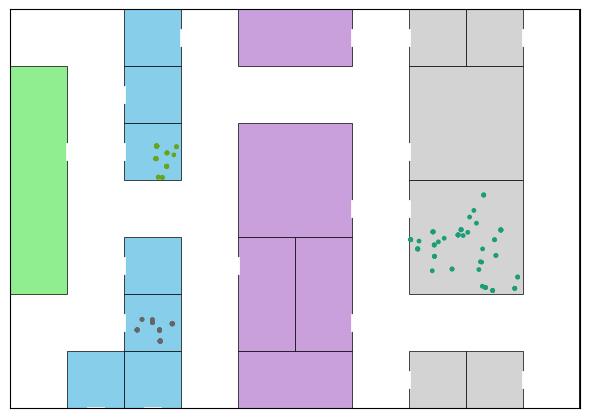

In [127]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = data.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
del cluster_mapping[-1]
mapped_clusters = merged_data_hdbscan['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
colors = list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [114]:

traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
hdbscan_stop_table = HDBSCAN.st_hdbscan(traj = data,
                                        is_long_lat = False,
                                        is_datetime = False,
                                        traj_cols = traj_cols,
                                        complete_output = True,
                                        time_thresh = 10,
                                        min_pts = 5,
                                        min_cluster_size = 10)
hdbscan_stop_table

,start_time,end_time,x,y,diameter,n_pings,duration,max_gap
cluster,,,,,,,,
2,1.717208e+09,1.717217e+09,19.861204,10.035797,2.015706,71.0,161.0,18.0
3,1.717200e+09,1.717203e+09,14.574002,11.594415,0.620968,51.0,51.0,2.0
4,1.717204e+09,1.717207e+09,14.624768,8.366804,0.625577,57.0,58.0,3.0


## Simple test synthetic data

In [42]:
# Synthetic dataset with connected 2 components connected by an edge with weight infinity
def synthetic_graph_with_cc():
    # MST edges within cluster A
    edges_a = [(1, 2, 0.15), (2, 3, 0.20)]
    # MST edges within cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.19)]
    # Artificial high-weight edge between cluster A and B
    bridge_edge = [(3, 4, np.inf)]

    # Combine into full MST+ext
    mst_ext_df = pd.DataFrame(edges_a + edges_b + bridge_edge, columns=["from", "to", "weight"])

    return mst_ext_df

# Synthetic dataset with connected 4 components
def synthetic_graph_with_4cc():
    # Cluster A
    edges_a = [(1, 2, 0.1), (2, 3, 0.15)]
    # Cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.2)]
    # Cluster C
    edges_c = [(7, 8, 0.05), (8, 9, 0.12)]
    # Cluster D
    edges_d = [(10, 11, 0.08), (11, 12, 0.18)]

    # Bridge edges with high weights
    bridges = [
        (3, 4, np.inf),  # A to B
        (6, 7, 20),  # B to C
        (9, 10, 15)  # C to D
    ]

    all_edges = edges_a + edges_b + edges_c + edges_d + bridges
    mst_ext_df = pd.DataFrame(all_edges, columns=["from", "to", "weight"])

    return mst_ext_df

In [14]:
def visualize_mst(mst_df):
    G = nx.Graph()

    for u, v, w in mst_df.itertuples(index=False):
        w_val = 1e6 if np.isinf(w) else w
        inv_w = 1.0 / w_val if w_val > 0 else 0.001
        label = "∞" if np.isinf(w) else f"{w:.2f}"
        G.add_edge(u, v, weight=w_val, inv_weight=inv_w, label=label)

    # Use inverse weights for layout
    pos = nx.spring_layout(G, weight='inv_weight')

    # Retrieve edge labels from edge attributes
    edge_labels = nx.get_edge_attributes(G, 'label')

    # Plot
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("MST Extended Graph with Edge Weights")
    plt.axis('off')
    plt.show()

def visualize_adjacency_dict(G_dict):
    """
    Visualize an adjacency dictionary as a NetworkX graph.

    Parameters
    ----------
    G_dict : dict
        Output of _build_graph() — {node: set(neighbors)}
    """
    # Convert dict-of-sets into a networkx Graph
    G = nx.Graph()
    for u, neighbors in G_dict.items():
        for v in neighbors:
            G.add_edge(u, v)

    print(G.number_of_nodes())

    pos = nx.spring_layout(G, seed=42)

    # Draw graph
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightgreen',
        edge_color='gray',
        node_size=200,
        font_size=10
    )
    plt.title("Connected Component After Edge Removal")
    plt.tight_layout()
    plt.show()

,from,to,weight
0,1,2,0.10
1,2,3,0.15
2,4,5,0.10
3,5,6,0.20
4,7,8,0.05
5,8,9,0.12
6,10,11,0.08
7,11,12,0.18
8,3,4,inf
9,6,7,20.00


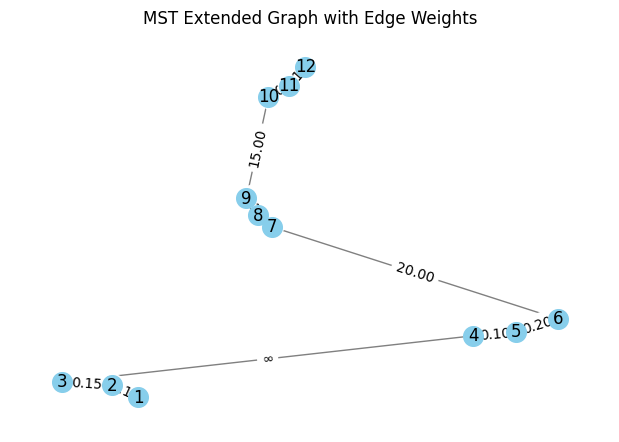

In [ ]:
# mst_4cc = synthetic_graph_with_4cc()
# display(mst_4cc)
# visualize_mst(mst_4cc)

,from,to,weight
0,1,2,0.15
1,2,3,0.20
2,4,5,0.10
3,5,6,0.19
4,3,4,inf


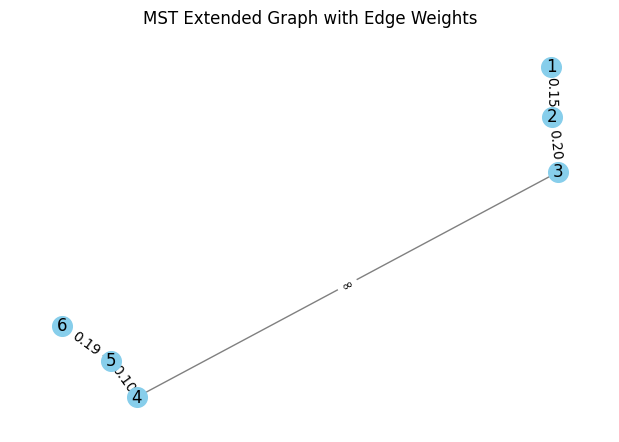

In [ ]:
# mst_ext_df = synthetic_graph_with_cc()
# display(mst_ext_df)
# visualize_mst(mst_ext_df)

- λ_min(Ci): minimum density level at which Ci exists
    - ε_max(Ci): maximum ε value (scale) at which Ci exisits
- λ_max(xj,Ci): the density level beyond which object xj no longer belongs to cluster Ci
    - ε_min(xj , Ci): ε value (scale) beyond which object xj no longer belongs to cluster Ci

In [ ]:
# cluster_stability_df = pd.DataFrame({
#     "cluster_id": [2,3,4,5,6,7,8,9,10,11],
#     "cluster_stability": [7,5,6,6,2,1,1,1,2,2]
# })

# hierarchy_df = pd.DataFrame({
#     "child": [2,3,4,5,6,7,8,9,10,11],
#     "parent": [0,0,2,2,3,3,5,5,8,8],
#     "scale": [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]
# }) 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
from collections import defaultdict


def plot_condensed_tree(hierarchy_df, label_history_df, selected_clusters=None, max_rectangles_per_cluster=20):
    # Count number of points per cluster per scale
    label_history_df = label_history_df.dropna(subset=['dendrogram_scale'])
    count_df = (
        label_history_df.groupby(['cluster_id', 'dendrogram_scale'])
        .size()
        .reset_index(name='count')
    )

    # Collect parent -> children relationships
    children_map = defaultdict(list)
    parent_map = {}
    for _, row in hierarchy_df.iterrows():
        children_map[row['parent']].append(row['child'])
        parent_map[row['child']] = row['parent']

    # Assign horizontal positions
    x_positions = {}
    curr_x = 0

    def assign_x(cid):
        nonlocal curr_x
        if cid not in children_map:
            x_positions[cid] = curr_x
            curr_x += 1
        else:
            for child in children_map[cid]:
                assign_x(child)
            children_x = [x_positions[child] for child in children_map[cid]]
            x_positions[cid] = sum(children_x) / len(children_x)

    assign_x(0)  # root is cluster 0

    # Prepare rectangles and optional split lines
    patches_list = []
    colors = []
    line_xs = []
    line_ys = []
    cluster_bounds = {}

    for cid, group in count_df.groupby('cluster_id'):
        group = group.sort_values('dendrogram_scale')
        n_bars = min(len(group), max_rectangles_per_cluster)
        step = max(1, len(group) // n_bars)

        for idx in range(0, len(group), step):
            row = group.iloc[idx]
            scale = row['dendrogram_scale']
            count = row['count']
            width = count / 10.0
            center_x = x_positions.get(cid, 0)
            bottom = 1 / scale if np.isfinite(scale) and scale > 0 else 0

            rect = patches.Rectangle(
                (center_x - width / 2, bottom),
                width,
                0.2
            )
            patches_list.append(rect)
            colors.append(count)

            if cid not in cluster_bounds:
                cluster_bounds[cid] = [center_x - width / 2, center_x + width / 2, bottom, bottom + 0.2]
            else:
                cluster_bounds[cid][2] = min(cluster_bounds[cid][2], bottom)
                cluster_bounds[cid][3] = max(cluster_bounds[cid][3], bottom + 0.2)

    # Prepare split lines
    for child, parent in parent_map.items():
        if child in x_positions and parent in x_positions:
            x0 = x_positions[parent]
            x1 = x_positions[child]
            scale_row = hierarchy_df[(hierarchy_df['parent'] == parent) & (hierarchy_df['child'] == child)]
            if not scale_row.empty:
                scale = scale_row['scale'].values[0]
                if np.isfinite(scale) and scale > 0:
                    y = 1 / scale
                    line_xs.append([x0, x1])
                    line_ys.append([y, y])


    fig, ax = plt.subplots(figsize=(10, 6))
    collection = PatchCollection(patches_list, cmap='viridis', edgecolor='black', linewidths=0.5)
    collection.set_array(np.array(colors))
    ax.add_collection(collection)
    plt.colorbar(collection, ax=ax, label='Number of points')
    ax.set_ylabel("$λ$ value (1 / scale)")
    ax.set_xlabel("Cluster layout")
    ax.set_title("Condensed Cluster Tree")

    for xs, ys in zip(line_xs, line_ys):
        ax.plot(xs, ys, color='black', linewidth=1)

    if selected_clusters:
        for cid in selected_clusters:
            if cid not in cluster_bounds:
                continue
            x0, x1, y0, y1 = cluster_bounds[cid]
            width = x1 - x0
            height = y1 - y0
            center = (x_positions[cid], (y0 + y1) / 2)
            ellipse = patches.Ellipse(center, 2 * width, 1.5 * height, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(ellipse)

    finite_scales = [scale for scale in count_df['dendrogram_scale'].values if np.isfinite(scale) and scale != 0]
    if finite_scales:
        max_lambda = max(1 / scale for scale in finite_scales)
        ax.set_ylim(0, max_lambda)
    else:
        ax.set_ylim(0, 1)
        
    ax.invert_yaxis()
    ax.set_xlim(-1, curr_x + 1)
    plt.tight_layout()
    plt.show()


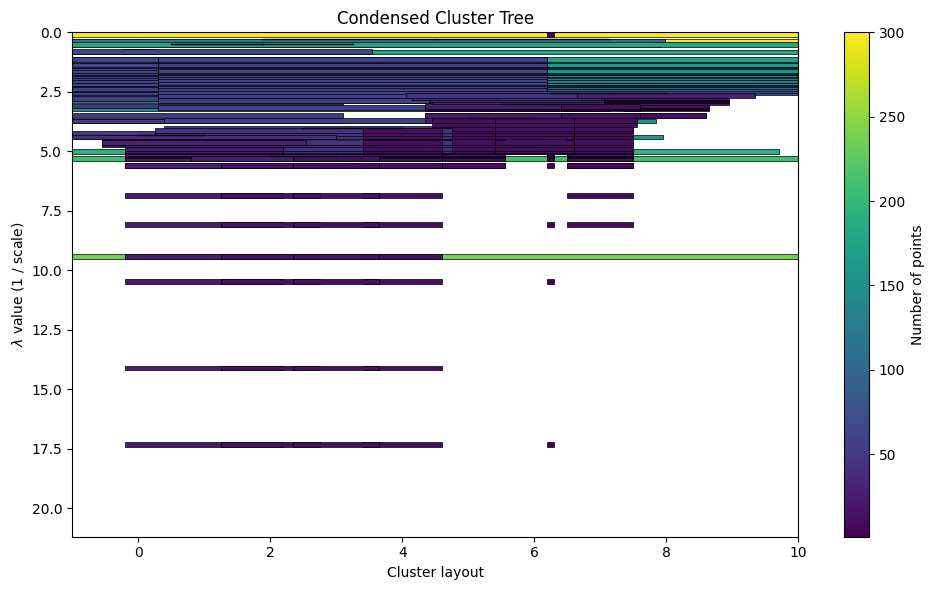

In [19]:
plot_condensed_tree(hierarchy_df, label_history_df)